In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dowhy import CausalModel
import dowhy
import networkx as nx
G = nx.Graph()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [149]:
df = pd.read_csv('./data/heart.csv')

In [150]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [151]:
df.shape

In [152]:
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
test = df[~mask]

In [153]:
train.to_csv('data/train.csv')
test.to_csv('data/test.csv')

In [154]:
columns = list(df.columns)
columns.remove(['fbs','target'])

ValueError: list.remove(x): x not in list

In [155]:
columns

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target']

In [90]:
graph = "graph[directed 1 "
for node in df.columns:
    graph += f'node[id "{node}" label "{node}"] '

graph += 'node[id "Unobserved Confounders" label "Unobserved Confounders"] '

for col in columns:
    graph += f'edge[source "{col}" target "target"] '

graph += f'edge[source "Unobserved Confounders" target "target"] '
graph += f'edge[source "Unobserved Confounders" target "sex"]]'

## Model

Create a model with structured graph and feed the doWhy Library

In [128]:
varibs = 'm + n'
varibs.split('+')

['m ', ' n']

In [129]:
model = CausalModel(data=train,
                   treatment=['sex'],
                   outcome=['target'],
                   common_causes=columns
                   )

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['sex'] on outcome ['target']


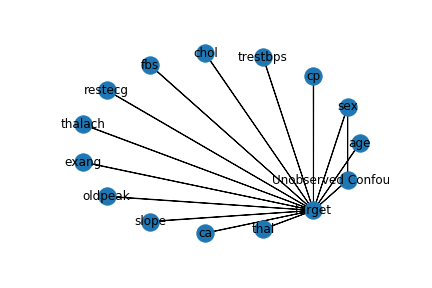

In [130]:
from IPython.display import Image,display
display(Image(filename='causal_model.png'))

## Identify

Use the identify_effect method to find the causal effect of our treatment to our outcome. model finds its way of finding causal effect. Similar to fit in sklearn

In [131]:
# I clicked on no bu I put the unobserved confounders to the nodes in graph dont know why
identified_estimand = model.identify_effect()

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['thal', 'cp', 'thalach', 'chol', 'age', 'fbs', 'exang', 'restecg', 'ca', 'oldpeak', 'trestbps', 'U', 'slope']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


## Estimate
Matching
Instrumental Variables

It will return propensity stratification and propensity score.

DoWhy library uses backdoort these methods to estimate the effect of X on Y.

**Propensity based Stratificaiton** 



**Propensity Score**


### Linear Regression

In [139]:
estimate_lin = model.estimate_effect(identified_estimand, method_name='backdoor.linear_regression',
                                test_significance=True)
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: target~sex+thal+cp+thalach+chol+age+fbs+exang+restecg+ca+oldpeak+trestbps+slope


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                           
──────(Expectation(target|thal,cp,thalach,chol,age,fbs,exang,restecg,ca,oldpea
d[sex]                                                                        

                  
k,trestbps,slope))
                  
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→target then P(target|sex,thal,cp,thalach,chol,age,fbs,exang,restecg,ca,oldpeak,trestbps,slope,U) = P(target|sex,thal,cp,thalach,chol,age,fbs,exang,restecg,ca,oldpeak,trestbps,slope)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: target~sex+thal+cp+thalach+chol+age+fbs+exang+restecg+ca+oldpeak+trestbps+slope
## Estimate
Value: -0.06956521739130433



In [140]:
print("Causal Estimate is " + str(estimate_lin.value))
data_1 = df[df["exang"]==1]
data_0 = df[df["exang"]==0]

print("ATE", np.mean(data_1["target"])- np.mean(data_0["target"]))

Causal Estimate is -0.17321283292079898
ATE -0.46375519904931667


## Propesity Score Matching

In [134]:
estimate = model.estimate_effect(identified_estimand,method_name='backdoor.propensity_score_matching')


print("Causal Estimate is " + str(estimate.value))

print("ATE", np.mean(data_1["target"])- np.mean(data_0["target"]))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: target~sex+thal+cp+thalach+chol+age+fbs+exang+restecg+ca+oldpeak+trestbps+slope


Causal Estimate is -0.06956521739130433
ATE -0.46375519904931667


## Refute
To prove if the statement is right or wrong we will implement
1. Placebo Treatment
2. Irrelevant additional Confounder
3. Subset validation

In [136]:
refute_results = model.refute_estimate(identified_estimand, estimate, 
                                      method_name='random_common_cause')
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: target~sex+thal+cp+thalach+chol+age+fbs+exang+restecg+ca+oldpeak+trestbps+slope+w_random


Refute: Add a Random Common Cause
Estimated effect:(-0.06956521739130433,)
New effect:(-0.09130434782608696,)



In [141]:
# placebo for linearestimand
refute_results = model.refute_estimate(identified_estimand, estimate_lin, 
                                      method_name='placebo_treatment_refuter',
                                      placebo_type='permute')
print(refute_results)


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: target~placebo+thal+cp+thalach+chol+age+fbs+exang+restecg+ca+oldpeak+trestbps+slope


Refute: Use a Placebo Treatment
Estimated effect:(-0.17321283292079898,)
New effect:(-0.02252418043817561,)



In [137]:
refute_results = model.refute_estimate(identified_estimand, estimate, 
                                      method_name='placebo_treatment_refuter',
                                      placebo_type='permute')
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: target~placebo+thal+cp+thalach+chol+age+fbs+exang+restecg+ca+oldpeak+trestbps+slope


Refute: Use a Placebo Treatment
Estimated effect:(-0.06956521739130433,)
New effect:(0.12608695652173912,)



In [138]:
refute_results = model.refute_estimate(identified_estimand, estimate, 
                                      method_name='data_subset_refuter',
                                      subset_fraction=0.9)
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: target~sex+thal+cp+thalach+chol+age+fbs+exang+restecg+ca+oldpeak+trestbps+slope


Refute: Use a subset of data
Estimated effect:(-0.06956521739130433,)
New effect:(-0.06763285024154589,)

